In [2]:
#PyMC Example
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm

data = ascii.read('Cepheids_DATA_all.csv')

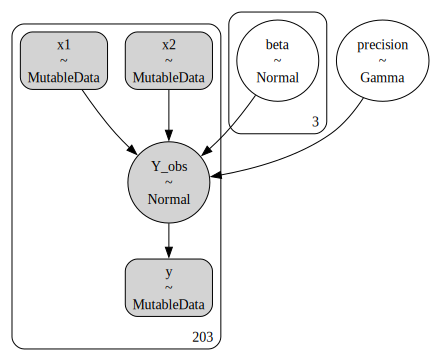

In [3]:
from pymc import Model, Normal, Gamma,model_to_graphviz
basic_model = Model() #<1>
with basic_model as basic: #<2>
    y=pm.MutableData(name='y',value =data['MV']) #<3> -- UNOBSERVED RV
    x1=pm.MutableData(name='x1',value =data['LogP'])
    x2=pm.MutableData(name='x2',value =data['[Fe/H]'])
    # Priors for unknown model parameters -- PRIOR DISTRIBUTIONS
    beta = Normal('beta', mu=0, tau=1./10, shape=3) #<4>
    precision = Gamma('precision', alpha=1, beta=1)
    # Expected value of outcome
    mu =beta[0] + beta[1]*x1 + beta[2]*x2 #<5>
    # Likelihood (sampling distribution) of observations-- OBSERVED RV
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)
    #<6>↪
model_to_graphviz(basic)

In [4]:
with basic:
    #Draw 1000 posterior samples
    idata = pm.sample()
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [5]:
# first 5 values for lambda from 4 chains
idata.posterior["precision"].sel(draw=slice(0, 4))

<xarray.DataArray 'precision' (chain: 4, draw: 5)>
array([[2.38956548, 3.15827862, 2.92297594, 2.57565287, 2.84293192],
       [3.11238449, 2.68384093, 2.5900774 , 2.68509094, 2.62156719],
       [2.27580236, 2.23390761, 3.15765418, 2.81794924, 2.87169899],
       [2.85085225, 2.70582844, 2.76407787, 2.65571902, 2.85980869]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

In [8]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'STEP_METHODS',
 'Slice',
 'UniformProposal']

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

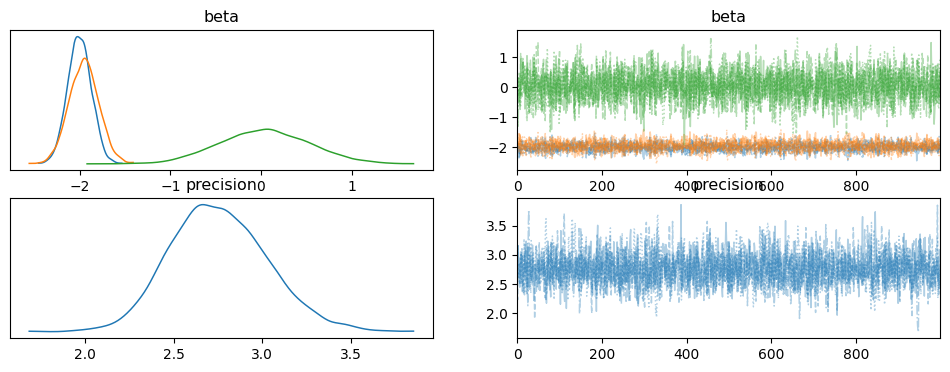

In [15]:
az.plot_trace(idata,combined=True)

In [9]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-2.00,0.13,-2.24,-1.76,0.00,0.00,1982.65,2222.54,1.0
beta[1],-1.95,0.16,-2.25,-1.63,0.00,0.00,2027.37,2203.70,1.0
beta[2],0.04,0.49,-0.90,0.92,0.01,0.01,2795.70,2228.89,1.0
precision,2.76,0.28,2.27,3.30,0.01,0.00,2592.60,2268.89,1.0


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

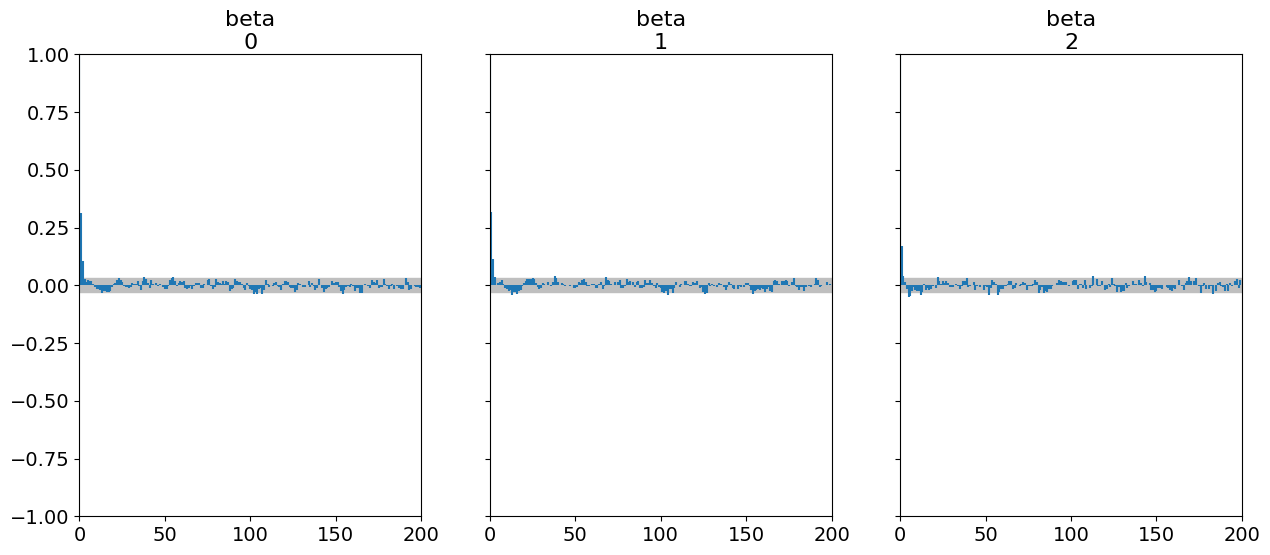

In [10]:
#autocorrelation visualization to see if there are errors with sampling
az.plot_autocorr(idata, var_names=['beta'], filter_vars="like",
max_lag=200,combined=True, figsize=(15, 6))

In [17]:
# Measurement Error Example
# Simulated Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
n=40
beta=np.array([2,-1])
x = np.linspace(1,10,n)
#generate truth
y = x * beta[0] +beta[1]
# y with intrinsic scatter
scatter = 0.4
isc = np.random.randn(n) * scatter
y_is = y + isc
# generate error on x
std_x = 2
e_x= np.random.randn(n) * std_x
x_st = x+ e_x
# generate error on y
std_y = 1.5
e_y= np.random.randn(n) * std_y
y_st = y + e_y



In [18]:
from scipy.stats import linregress
from scipy.stats import t
result = linregress(x_st, y_is+e_y)
print(result.intercept, result.intercept_stderr)

1.817801403870492 1.2070167668984433
